In [5]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from skimage.external.tifffile import imread
from skimage import io
import os
from os.path import join as oj
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.linear_model import LinearRegression, LogisticRegression, RidgeCV
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_validate, train_test_split
import data
import numpy as np
from sklearn.datasets import make_classification
from torch import nn
import torch.nn.functional as F
import torch
from sklearn import metrics
from skorch import NeuralNetClassifier
from skorch import NeuralNetRegressor
import models
from skorch.callbacks import Checkpoint, TrainEndCheckpoint
plt.style.use('dark_background')

X, Y = data.get_data()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
X_patches, Y_centers = data.extract_patch_features(X, Y)
Y_centers -= np.min(Y_centers) # make all vals positive
print('shapes', X_patches.shape, Y_centers.shape)

X_train, X_test, Y_train, Y_test = train_test_split(X_patches, Y_centers, 
                                                    test_size=0.33, random_state=42)

shapes (109174, 9, 9, 300) (109174,)


# linear model

In [51]:
n = 10000
X_flat = X_patches[:n].reshape(n, -1)
Y_flat = Y_centers[:n]

In [ ]:
# m = LinearRegression()
m = RidgeCV(store_cv_values=True)
m_fit = m.fit(X_flat, Y_flat)

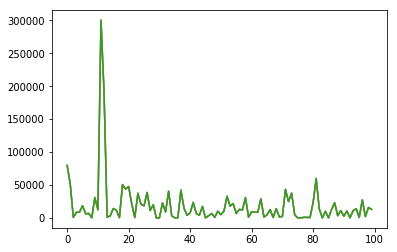

In [9]:
plt.plot(m_fit.cv_values_)

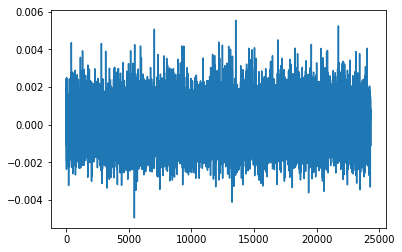

In [46]:
plt.plot(m.coef_)

In [46]:
print('score', m.score(X_flat, Y_flat))

score 0.9999999999999848


# multi-linear model

In [ ]:
from models import MaxLinear

net = NeuralNetRegressor(
    MaxLinear(),
    max_epochs=1000,
    batch_size=1000,
    lr=1e-6,
    iterator_train__shuffle=True,
    optimizer=torch.optim.Adam,
)

X = X_flat.astype(np.float32)
Y = Y_flat.reshape(-1, 1).astype(np.float32)
# X, y = make_classification(1000, 20, n_informative=10, random_state=0)
# X = X.astype(np.float32)
# y = y.astype(np.int64)

net.fit(X, Y)


Text(0, 0.5, 'Yhat')

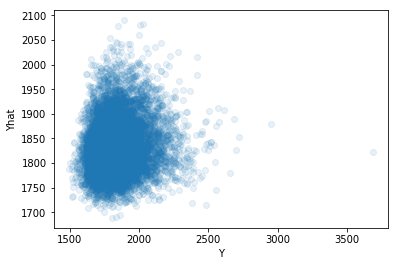

In [68]:
yhat = net.predict(X)
plt.plot(Y, yhat, 'o', alpha=0.1)
# sns.lmplot(Y.astype(np.float32), yhat.astype(np.float32))
plt.xlabel('Y')
plt.ylabel('Yhat')

In [71]:
n = 1000
X_flat = X_patches[:n] #.reshape(n, -1)
Y_flat = Y_centers[:n]

In [72]:
X_patches.shape

(109174, 9, 9, 300)

In [6]:
m = models.MaxConvLinear(num_timepoints=300, num_linear_filts=1, num_conv_filts=2, patch_size=9,
                         kernel_size=8, use_bias=False)
m.forward(torch.tensor(X_train[:10]))

in shape torch.Size([10, 300, 81]) torch.float32
out shape torch.Size([10, 2, 293]) torch.float32
out2 shape torch.Size([10]) torch.float32


tensor([[0.6068],
        [1.2615],
        [0.6729],
        [0.2188],
        [1.3093],
        [1.3121],
        [0.8059],
        [1.3955],
        [0.6404],
        [1.6787]], grad_fn=<UnsqueezeBackward0>)

In [7]:
dirname = 'conv_lin=3_conv2'
# dirname = 'conv_size=8_num_chanels=30' # conv_size x num_conv
# train_end_cp = TrainEndCheckpoint(dirname='exp1')
# net = NeuralNetClassifier(
#     MyModule, lr=0.5, callbacks=[cp, train_end_cp]
# )

net = NeuralNetRegressor(
    models.MaxConvLinear(num_timepoints=300, num_linear_filts=3, num_conv_filts=2, patch_size=9,
                         kernel_size=8, use_bias=False),
    max_epochs=1000,
    batch_size=1000,
    lr=1e-2,
    iterator_train__shuffle=True,
    optimizer=torch.optim.SGD,
    callbacks=[Checkpoint(dirname=dirname)],
    device='cuda'
)

In [8]:
# train
net.fit(X_train, Y_train.reshape(-1, 1))
# pkl.dump(net, open( "net_big.pkl", "wb" ))

  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1        3.4047        1.8626     +  7.2221
      2        1.3873        1.0293     +  8.0183
      3        0.9663        0.9122     +  7.1306
      4        0.9232        0.9117     +  7.3307
      5        0.9156        0.9073     +  7.5932
      6        0.9112        0.9090        7.1045
      7        0.9073        0.9044     +  7.2178
      8        0.9044        0.9087        7.4364
      9        0.9026        0.9044     +  7.2245
     10        0.8992        0.9038     +  7.1151
     11        0.8976        0.9020     +  7.1376
     12        0.8958        0.9075        7.4362


<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=MaxConvLinear(
    (fc1): Linear(in_features=81, out_features=3, bias=False)
    (conv1): Conv1d(3, 2, kernel_size=(8,), stride=(1,), bias=False)
  ),
)

Re-initializing optimizer.
(6, 8)
offset 0.0


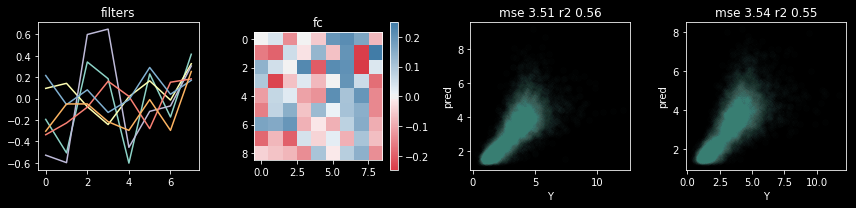

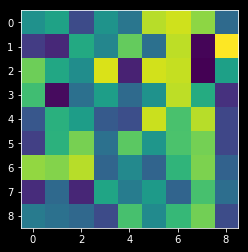

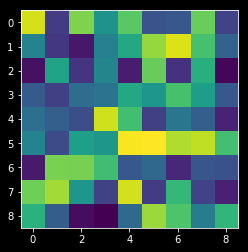

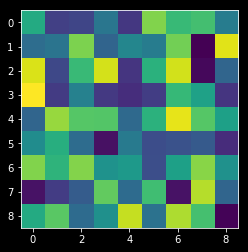

In [11]:
# load trained model and plot
net.initialize() # This is important!
net.load_params(
    f_params=oj(dirname, 'params.pt'), f_optimizer=oj(dirname, 'optimizer.pt'), f_history=oj(dirname, 'history.json')
)


R, C = 1, 4
n = 10000
ws = net.module_.state_dict()['conv1.weight'].cpu().numpy().squeeze()
s = ws.shape
if len(s) > 2:
    ws = ws.reshape(s[0] * s[1], s[2])
print(ws.shape)
print('offset', net.module_.state_dict()['offset'].cpu().numpy().squeeze())
plt.figure(figsize=(C*3, R*3))
plt.subplot(R, C, 1)
plt.title('filters')
plt.plot(ws.T)

plt.subplot(R, C, 2)
fcs = net.module_.state_dict()['fc1.weight'].cpu().numpy().squeeze()
fc = fcs[0]
plt.title('fc')
plt.imshow(fc.reshape(9, 9), cmap=sns.diverging_palette(10, 240, as_cmap=True))
plt.colorbar()

plt.subplot(R, C, 3)
preds = net.predict(X_train[:n].astype(np.float32))
plt.plot(Y_train[:n], preds, 'o', alpha=0.01)
plt.title(f'mse {np.mean(np.square(Y_train[:n] - preds)):0.2f} r2 {metrics.r2_score(Y_train[:n], preds):0.2f}')
plt.xlabel('Y')
plt.ylabel('pred')

plt.subplot(R, C, 4)
preds_test = net.predict(X_test[:n])
plt.plot(Y_test[:n], preds_test, 'o', alpha=0.01)
plt.title(f'mse {np.mean(np.square(Y_test[:n] - preds_test)):0.2f} r2 {metrics.r2_score(Y_test[:n], preds_test):0.2f}')
plt.xlabel('Y')
plt.ylabel('pred')

plt.tight_layout()
plt.savefig(dirname + '.png')
plt.show()

if fcs.shape[0] > 1:
    for i in range(fcs.shape[0]):
        plt.imshow(fcs[i].reshape(9, 9))
        plt.show()